In [ ]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torchmetrics


device = torch.device('cuda:0')

In [ ]:
shared_path ="/scratch/kl3108/DS1008/finalCompetition/" # change to your own path

# Load Dataset

In [ ]:
class VideoSegDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.video_folders = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        self.video_folders.sort()

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        video_folder = self.video_folders[idx]

        # Load segmentation masks
        mask_path = os.path.join(video_folder, 'mask.npy')
        masks = torch.from_numpy(np.load(mask_path)).long()  # Shape [22, 160, 240]

        # Split into input and target masks
        input_masks = masks[:11]   # First 11 masks
        target_masks = masks[11:]  # Last 11 masks

        # Add channel dimension
        # One-hot encode
        input_masks = torch.nn.functional.one_hot(input_masks, num_classes=49).permute(0, 3, 1, 2).float() # Shape [22, 49, 160, 240]

        return input_masks, target_masks

In [ ]:
val_subset = VideoSegDataset(root_dir='val/') # 100, from 1000-1999 random choice

In [ ]:
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, pin_memory=True)

# Load Model

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm=act_norm
        if not transpose:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=stride //2 )
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y

class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3,5,7,11], groups=8):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

In [ ]:
def stride_generator(N, reverse=False):
    '''
    ### 1. `stride_generator` Function
    This function generates a list of stride values for convolutional layers.
    A stride determines how far a convolutional filter moves across the input. In this function:
    - `strides = [1, 2]*10` creates a list of alternating 1s and 2s.
    - `N` specifies how many elements from this list to use.
    - If `reverse` is `True`, the list is reversed; otherwise, it's used as is.
    '''
    strides = [1, 2]*10
    if reverse: return list(reversed(strides[:N]))
    else: return strides[:N] # N should be less than 20

class Encoder(nn.Module):
    '''
    ### 2. `Encoder` Class
    This class defines an encoder module, typically used to downsample and extract features from the input.
    - `C_in` and `C_hid` are the number of input and hidden channels, respectively.
    - `N_S` is the number of strides, used to generate stride values.
    - `self.enc` is a sequential container of convolutional layers (`ConvSC`), where the first layer's stride is `strides[0]` and subsequent layers' strides are determined by the remaining elements in `strides`.
    '''
    def __init__(self,C_in, C_hid, N_S):
        super(Encoder,self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )

    def forward(self,x):# B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1,len(self.enc)):
            latent = self.enc[i](latent)
        return latent,enc1


class Decoder(nn.Module):
    '''
    ### 3. `Decoder` Class
    This class defines a decoder module, which typically upsamples the feature maps to reconstruct or generate output.
    - It uses the same stride values as the encoder but in reverse order. This symmetry is common in encoder-decoder architectures.
    - `ConvSC` with `transpose=True` indicates transposed convolution, often used for upsampling.
    - The final layer concatenates its input with the feature map `enc1` from the encoder, which is a form of skip connection, often used to help the network better learn fine-grained details.
    '''
    def __init__(self,C_hid, C_out, N_S):
        super(Decoder,self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True) for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0,len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y

class Mid_Xnet(nn.Module):
    '''
    ### 4. `Mid_Xnet` Class
    This class appears to be a middle processing network with multiple `Inception` modules.
    - It alternates between encoding and decoding Inception modules, with skip connections from encoder layers to corresponding decoder layers.
    '''
    def __init__(self, channel_in, channel_hid, N_T, incep_ker = [3,5,7,11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))

        dec_layers = [Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    '''
    ### 5. `SimVP` Class
    This is the main model class combining the Encoder, Mid_Xnet, and Decoder.
    - `shape_in` describes the shape of the input tensor.
    - The model first reshapes the input and passes it through the encoder.
    - The encoded output is reshaped again and passed through `Mid_Xnet`.
    - Finally, the output of `Mid_Xnet` is reshaped and decoded to produce the final output.
    '''
    def __init__(self, shape_in, hid_S=16, hid_T=256, N_S=4, N_T=8, incep_ker=[3,5,7,11], groups=8):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        self.enc = Encoder(C, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, C, N_S)


    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y

In [ ]:
model = SimVP(tuple([11,49,160,240]), 64, 256, 4, 8, [3,5,7,11], 7).to(device)
model.load_state_dict(torch.load(shared_path+'Sim_VP_best_model_segs_new_loss_9.pth'))

<All keys matched successfully>

# Jaccard on Validation

In [ ]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)
val_pbar = tqdm(val_loader)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
for i, (data, target) in enumerate(val_pbar):
    data, target = data.to(device), target.to(device)
    target_last = target[:,-1,:,:].squeeze() #32,160,240
    with torch.no_grad():  # No need to track gradients during validation
            pred_last = model(data)[:,-1,:,:,:].squeeze()    #batch,49,160,240
    pred_max = torch.argmax(pred_last,dim=1)
    jaccard.update(pred_max, target_last)
jaccard.compute()

100%|██████████| 32/32 [04:17<00:00,  8.04s/it]


tensor(0.2688, device='cuda:0')

In [ ]:
jaccard.compute()

tensor(0.2688, device='cuda:0')

# Visualization

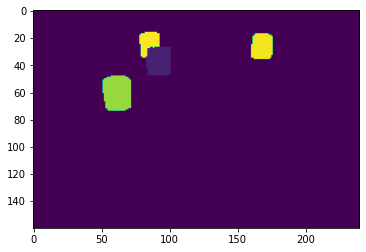

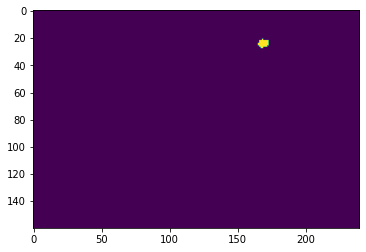

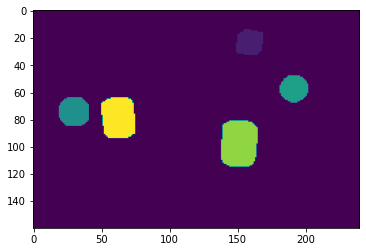

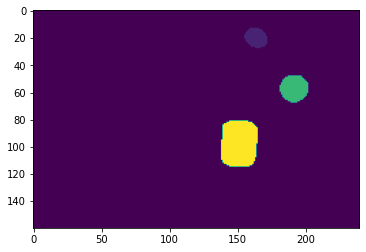

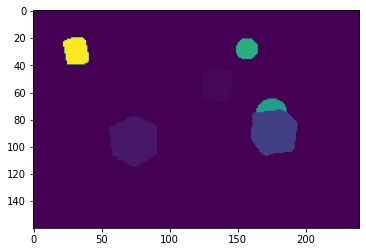

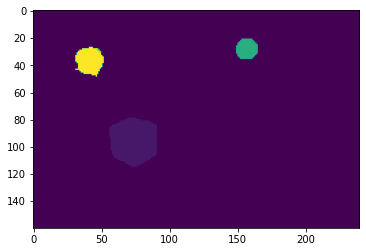

In [ ]:
for example_idx in [1000,1200,1050]:
    example_path = "val/video_"+str(example_idx)+"/mask.npy"
    masks = torch.from_numpy(np.load(example_path)).long()
    input_masks = masks[:11]   # First 11 masks
    input_masks = torch.nn.functional.one_hot(input_masks, num_classes=49).permute(0, 3, 1, 2).float()

    target_mask = masks[-1]  # Last 1 mask

    pred_result = model(input_masks.unsqueeze(0).to(device))[:,-1,:,:,:].squeeze()
    pred_mask = torch.argmax(pred_result,dim=0)

    plt.imshow(target_mask.cpu().numpy())
    plt.show()
    plt.imshow(pred_mask.cpu().numpy())
    plt.show()